# Projet - The Office

## Chargement des données

In [531]:
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize(verbose=0, progress_bar=True)

data = pd.read_csv('data_The_Office.csv')

# Dans le dataset fourni, il y a une dernière colonne détécté du à une virgule en trop a chaque fin de ligne dans le fichier csv, on supprime donc cette colonne
data = data.drop(data.columns[-1], axis=1)

data.head(5)

,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah."
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done."


## Visualisation des données

### 1. Word count

In [532]:
# Pour avoir le nombre de mots les plus fréquents, on va combiner toutes les lignes de dialogues en une seule
all_lines = ' '.join(data['line'].values)

# Affichage des 100 premiers caractères
print(all_lines[0:100])

All right Jim. Your quarterlies look very good. How are things at the library? Oh, I told you. I cou


In [533]:
# Pour avoir le nombre de mots les plus fréquents, on doit d'abord faire un premier nettoyage des données, pour enlever les ponctuations et mettre tout le texte en minuscule
import string

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

# On applique la fonction de nettoyage sur le texte
all_lines = clean_text(all_lines)

# Affichage des 100 premiers caractères
print(all_lines[0:100])

all right jim your quarterlies look very good how are things at the library oh i told you i couldnt 


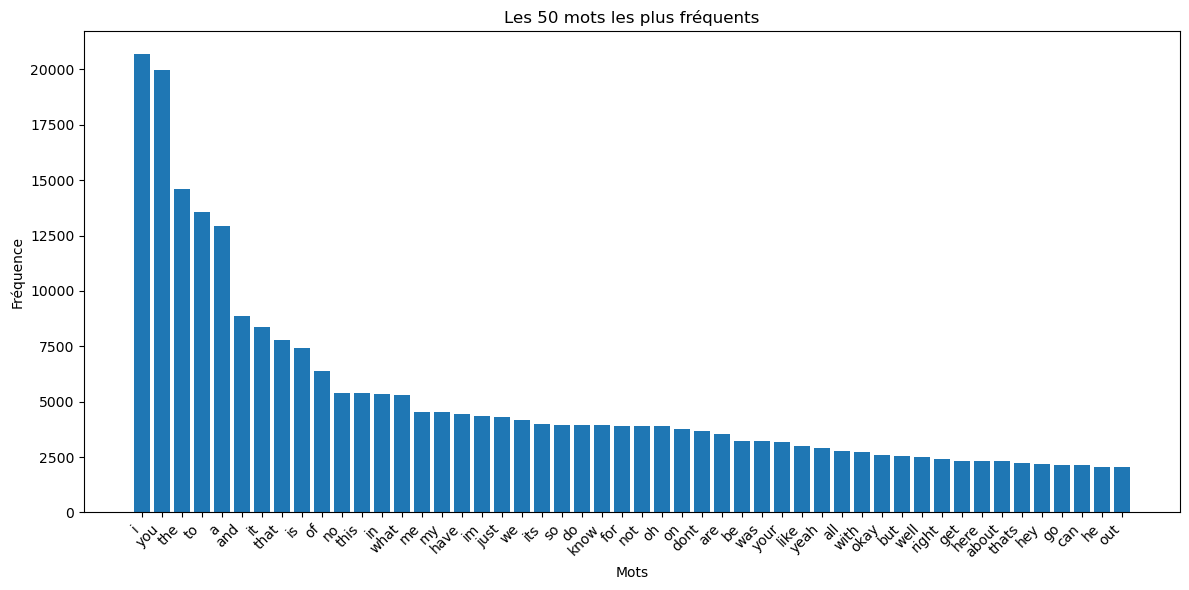

In [534]:
# On peut désormais compter le nombre de mots les plus fréquents
from collections import Counter

words = all_lines.split()
word_counts = Counter(words)

# On affiche les 10 mots les plus fréquents avec un barplot
import matplotlib.pyplot as plt

word_counts_df = pd.DataFrame(word_counts.most_common(50), columns=['word', 'count'])

plt.figure(figsize=(12, 6)) 
plt.bar(word_counts_df['word'], word_counts_df['count'])
plt.title('Les 50 mots les plus fréquents')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

Commme on pouvait s'en douter, les mots les plus fréquents sont des mots très courants que l'on appelle des stop words et qui n'apportent pas d'information. C'est pour cela que lors des pré-traitements on va les retirer pour ne pas fausser les résultats.

### 2. Personnages les plus présents

In [535]:
# Pour avoir les personnes les plus fréquents, on va simplement utiliser la colonne 'speaker' et compter le nombre de fois que chaque personne parle
speaker_counts = data['speaker'].value_counts()

print(speaker_counts.head(10))

speaker
Michael    10773
Dwight      6752
Jim         6222
Pam         4973
Andy        3698
Kevin       1535
Angela      1534
Erin        1413
Oscar       1336
Ryan        1182
Name: count, dtype: int64


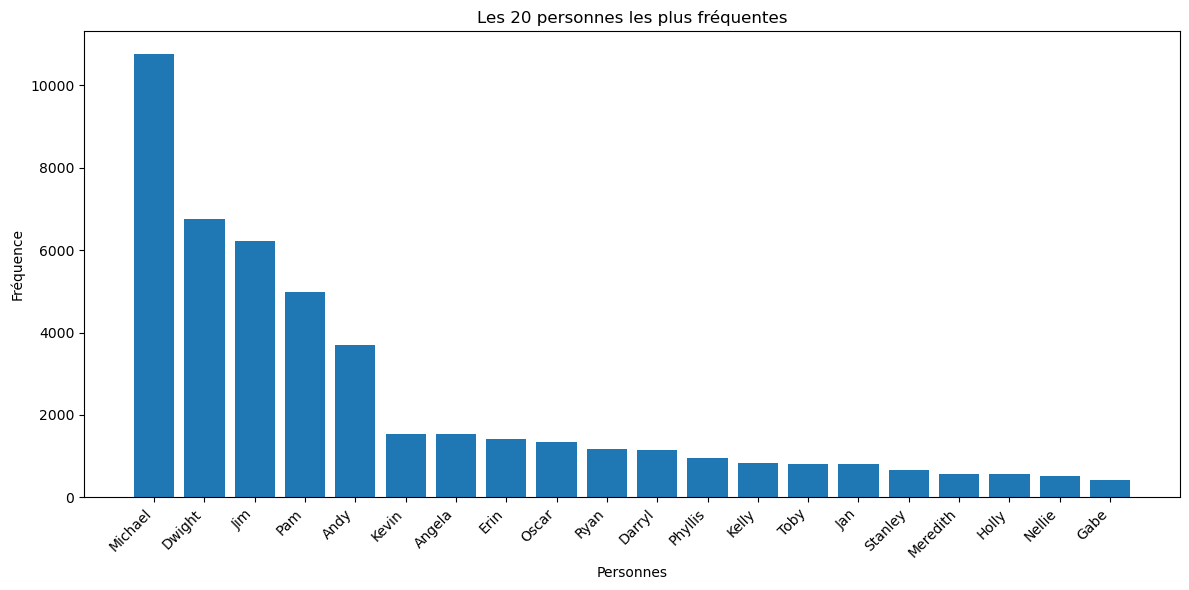

In [536]:
# On affiche désormais les 20 personnes les plus fréquentes sur un bar plot
plt.figure(figsize=(12, 6))
plt.bar(speaker_counts.head(20).index, speaker_counts.head(20).values)
plt.title('Les 20 personnes les plus fréquentes')
plt.xlabel('Personnes')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Si l'on connait la série, le graphique est assez logique, les 4 les plus présents dans les dialogues sont ceux que l'on voit toute la série et qui sont les principaux personnages.

Ensuite, les autres personnages sont plus ou moins présents en fonction de leur importance dans la série.

### 3. Interaction entre les personnages

In [537]:
# Pour représenter les interactions entre les personnages, on va utiliser les colonnes 'speaker' et 'scene' du dataset
# Le but est que pour chaque scène, on va compter le nombre d'interaction entre chaque paire de personnages

interaction = {}

last_scene = 0
last_speaker = ''
for line in data.itertuples():
    if line.scene == last_scene:
        if line.speaker != last_speaker:
            if (last_speaker, line.speaker) in interaction:
                interaction[(last_speaker, line.speaker)] += 1
            else:
                interaction[(last_speaker, line.speaker)] = 1
    else:
        last_scene = line.scene
        last_speaker = line.speaker

# On combine les interactions du type ('Jim', 'Pam') ('Pam, 'Jim') en une seule
interaction_unique = {}
for key, value in interaction.items():
    if (key[1], key[0]) in interaction:
        interaction_unique[key] = value + interaction[(key[1], key[0])]
    else:
        interaction_unique[key] = value

print(interaction_unique)

{('Michael', 'Jim'): 1170, ('Michael', 'Pam'): 1276, ('Michael', 'Dwight'): 1738, ('Jan', 'Michael'): 531, ('Jan', 'Pam'): 59, ('Michael', 'Jan'): 531, ('Michael', 'Michel'): 3, ('Michael', 'Todd Packer'): 31, ('Phyllis', 'Stanley'): 57, ('Angela', 'Kevin'): 104, ('Pam', 'Jim'): 1495, ('Michael', 'Ryan'): 406, ('Jim', 'Dwight'): 1284, ('Pam', 'Michael'): 1276, ('Michael', 'Oscar'): 363, ('Oscar', 'Michael'): 363, ('Oscar', 'Stanley'): 31, ('Oscar', 'Dwight'): 154, ('Oscar', 'Phyllis'): 50, ('Oscar', 'Pam'): 139, ('Oscar', 'Man'): 1, ('Dwight', 'Michael'): 1738, ('Jim', 'Pam'): 1495, ('Jim', 'Roy'): 61, ('Pam', 'Roy'): 83, ('Michael', 'Mr. Brown'): 27, ('Mr. Brown', 'Michael'): 27, ('Mr. Brown', 'Dwight'): 9, ('Mr. Brown', 'Kevin'): 3, ('Kevin', 'Michael'): 343, ('Kevin', 'Mr. Brown'): 3, ('Jim', 'Michael'): 1170, ('Michael', 'Toby'): 278, ('Michael', 'Kevin'): 343, ('Michael', 'Kelly'): 156, ('Michael', 'Stanley'): 264, ('Jim', 'Ryan'): 130, ('Kevin', 'Angela'): 104, ('Pam', 'Dwight'):

In [538]:
# Ensuite, on va diviser le nombre d'interaction par le nombre total de dialogue de chaque personnage pour avoir une fréquence
interaction_freq = {}
for key, value in interaction_unique.items():
    interaction_freq[key] = value / speaker_counts[key[0]]

print(interaction_freq)

{('Michael', 'Jim'): 0.1086048454469507, ('Michael', 'Pam'): 0.11844425879513598, ('Michael', 'Dwight'): 0.16132924904854729, ('Jan', 'Michael'): 0.6596273291925466, ('Jan', 'Pam'): 0.07329192546583851, ('Michael', 'Jan'): 0.04928989139515455, ('Michael', 'Michel'): 0.000278473962684489, ('Michael', 'Todd Packer'): 0.002877564281073053, ('Phyllis', 'Stanley'): 0.059251559251559255, ('Angela', 'Kevin'): 0.06779661016949153, ('Pam', 'Jim'): 0.30062336617735774, ('Michael', 'Ryan'): 0.037686809616634176, ('Jim', 'Dwight'): 0.2063645130183221, ('Pam', 'Michael'): 0.25658556203498895, ('Michael', 'Oscar'): 0.03369534948482317, ('Oscar', 'Michael'): 0.2717065868263473, ('Oscar', 'Stanley'): 0.023203592814371257, ('Oscar', 'Dwight'): 0.11526946107784432, ('Oscar', 'Phyllis'): 0.0374251497005988, ('Oscar', 'Pam'): 0.10404191616766467, ('Oscar', 'Man'): 0.0007485029940119761, ('Dwight', 'Michael'): 0.25740521327014215, ('Jim', 'Pam'): 0.24027643844423016, ('Jim', 'Roy'): 0.00980392156862745, ('

['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Kevin', 'Angela', 'Erin', 'Oscar', 'Ryan', 'Darryl', 'Phyllis', 'Kelly', 'Toby', 'Jan']
[[0, 0.16132924904854729, 0.1086048454469507, 0.11844425879513598, 0.03648008911166806, 0.03183885640025991, 0.021535319780933815, 0.021813793743618304, 0.03369534948482317, 0.037686809616634176, 0.02292768959435626, 0.0235774621739534, 0.014480646059593427, 0.025805253875429313, 0.04928989139515455], [0.25740521327014215, 0, 0.1901658767772512, 0.07123815165876778, 0.07790284360189574, 0.025770142180094786, 0.05998222748815166, 0.024437203791469193, 0.022808056872037914, 0.030065165876777253, 0.02014218009478673, 0.021919431279620854, 0.016735781990521326, 0.011700236966824644, 0.006072274881516588], [0.1880424300867888, 0.2063645130183221, 0, 0.24027643844423016, 0.06059144969463195, 0.03278688524590164, 0.013982642237222759, 0.015429122468659595, 0.021536483445837352, 0.020893603342976536, 0.022018643522982963, 0.01719704275152684, 0.012375441980070716

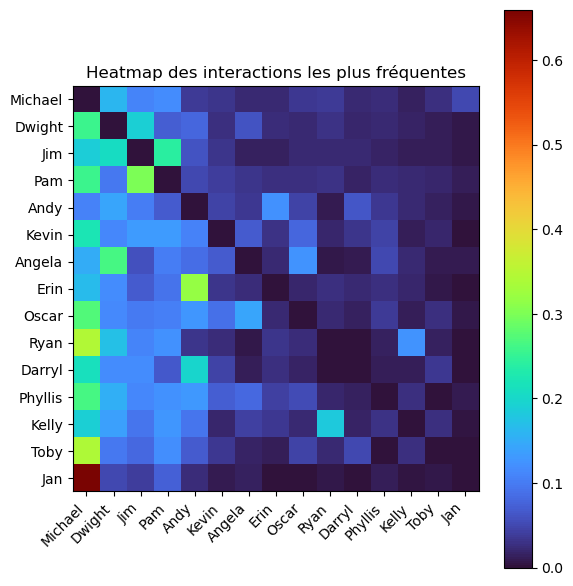

In [539]:
# On peut désormais afficher les interactions les plus fréquentes sur une heatmap
import matplotlib.pyplot as plt

speakers = list(speaker_counts.head(15).index)
interactions = [[interaction_freq[(speaker1, speaker2)] if (speaker1, speaker2) in interaction_freq else 0 for speaker2 in speakers] for speaker1 in speakers]

print(speakers)
print(interactions)

plt.figure(figsize=(6, 6))
plt.imshow(interactions, cmap='turbo', interpolation='nearest')
plt.xticks(range(len(speakers)), speakers, rotation=45, ha='right')
plt.yticks(range(len(speakers)), speakers)
plt.colorbar()
plt.title('Heatmap des interactions les plus fréquentes')
plt.tight_layout()
plt.show()

On peut lire le graphique de la façon suivante : Michael est très présent dans les discussions de Jan, mais Jan n'est pas tant présente dans les discussions de Michael. (C'est du au fait que Michael a beaucoup de dialogues avec de nombreux personnages)

De même, on peut voir que Michael est présent pour beaucoup de personnages, ce qui est logique étant donné qu'il est le patron de l'entreprise.

Et pour finir, on peut observer une fréquence assez forte et réciproque entre Jim et Pam, ce qui est normal étant donné qu'ils sont très proche tout au long de la série

## Pré-traitements

Dans cette partie, nous allons effectuer un certain nombre de pré-traitements :

- Suppression des lignes ayant des personnages qui ne sont pas assez présents (moins de 500 lignes de dialogue)
- Choix aléatoire de 500 lignes de dialogue par personnage (pour éviter la sur-représentation de certains personnages)
- Passage en minuscule, suppression des stop words, ponctuation et autres caractères spéciaux
- Lemmatisation

In [540]:
# Avant de faire la première étape, nous pouvons dès a présent supprimer les colonnes non-utilisées du dataset
data = data.drop(['season', 'episode', 'title', 'scene'], axis=1)

data.head(5)

,speaker,line
0,Michael,All right Jim. Your quarterlies look very good...
1,Jim,"Oh, I told you. I couldn't close it. So..."
2,Michael,So you've come to the master for guidance? Is ...
3,Jim,"Actually, you called me in here, but yeah."
4,Michael,"All right. Well, let me show you how it's done."


In [541]:
# On supprime une première fois les lignes des personnages qui ont moins de 750 dialogues (cela va permettre d'aller légèrement plus rapidement pour la suite)
print("Nombre de lignes avant le nettoyage : ", data.shape[0])

speaker_counts = data['speaker'].value_counts()
speakers_to_keep = speaker_counts[speaker_counts >= 750].index
data = data[data['speaker'].isin(speakers_to_keep)]

print("Nombre de lignes après le nettoyage : ", data.shape[0])

Nombre de lignes avant le nettoyage :  54626
Nombre de lignes après le nettoyage :  43981


In [542]:
# Nettoyage du texte
import spacy
import string

nlp = spacy.load("en_core_web_sm")
spacy_stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)

def clean_text(text):
    text = text.lower().strip()
    text = text.replace('\n', ' ')
    text = ' '.join([word for word in text.split() if word not in spacy_stopwords])
    text = ''.join([char for char in text if char not in string.punctuation])

    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc]
    text = ' '.join(lemmatized)

    return text

data['line'] = data['line'].parallel_apply(clean_text)

data.head(5)

,speaker,line
0,Michael,right jim quarterly look good thing library
1,Jim,oh tell you could not close it so
2,Michael,you ve come master guidance you re say grassho...
3,Jim,actually call here yeah
4,Michael,right well let its do


In [543]:
# Avant de choisir 750 dialogues pour chaque personnage, on va d'abord supprimer toutes les lignes vides et les lignes avec moins de 10 mots
print("Nombre de lignes avant le nettoyage : ", data.shape[0])

data = data[data['line'].str.len() > 40]
#data = data[data['line'].str.len() < 55]

print("Nombre de lignes après le nettoyage : ", data.shape[0])

Nombre de lignes avant le nettoyage :  43981
Nombre de lignes après le nettoyage :  10769


In [544]:
# On enlève de nouveau les personnages qui ont moins de 750 dialogues
print("Nombre de lignes avant le nettoyage : ", data.shape[0])

speaker_counts = data['speaker'].value_counts()
speakers_to_keep = speaker_counts[speaker_counts >= 750].index
data = data[data['speaker'].isin(speakers_to_keep)]

print("Nombre de lignes après le nettoyage : ", data.shape[0])

Nombre de lignes avant le nettoyage :  10769
Nombre de lignes après le nettoyage :  8532


In [545]:
#Choix aléatoire de 750 dialogues pour chaque personnage
data_sample = data.groupby('speaker').sample(n=750, random_state=42)

print(data_sample['speaker'].value_counts())

speaker
Andy       750
Dwight     750
Jim        750
Michael    750
Pam        750
Name: count, dtype: int64


In [546]:
print(data_sample.head(10))

      speaker                                               line
51653    Andy  speak metaphorically course know lot iron quot...
15683    Andy  need advice I ve spend lot time make angela la...
24153    Andy  hate soccer guess do not hate soccer charles m...
51713    Andy  oh go january seventh 2013 hey andy all well m...
41654    Andy          get it dually note you cool tank see that
51914    Andy  contract mutually agree to ah phrase like dagg...
35761    Andy  eat powdered seahorse admit think go to work t...
53904    Andy  hey what s goin here sort singe competition yo...
18360    Andy  I m excited lose weight wedding want washboard...
48744    Andy  do not any question old day want know boner champ


Notre jeu de données est maintenant prêt pour l'entraînement de nos modèles.

## Séparation et vectorisation des données

In [547]:
# On peut désormais séparer les données
from sklearn.model_selection import train_test_split

X = data_sample['line']
y = data_sample['speaker']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train:', len(X_train), 'texts', 'Test:', len(X_test), 'texts')

Train: 3000 texts Test: 750 texts


In [548]:
# On va maintenant transformer les textes en vecteurs
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


weights = np.asarray(X_train_vectorized.mean(axis=0)).ravel().tolist()

weights_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'weight': weights})

weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
3765,not,0.035947
1689,do,0.029787
6180,you,0.027343
3113,know,0.026893
2378,go,0.024801
2947,its,0.023302
3227,like,0.021532
5570,think,0.020411
5549,that,0.020273
4479,re,0.018611


## Entraînement des modèles

Pour l'entrainement des modèles, nous allons tester 2 modèles différents :

- SVM
- Régression logistique
- Random Forest
- Gradient Boosting

### SVM


In [549]:
# On va maintenant entrainer un modèle de classification SVM
from sklearn import svm

svm_classifier = svm.LinearSVC()
svm_classifier.fit(X_train_vectorized, y_train)

/home/nirs123/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

              precision    recall  f1-score   support

        Andy       0.43      0.35      0.39       169
      Dwight       0.40      0.44      0.42       149
         Jim       0.37      0.41      0.39       145
     Michael       0.39      0.35      0.37       147
         Pam       0.39      0.44      0.41       140

    accuracy                           0.39       750
   macro avg       0.40      0.40      0.39       750
weighted avg       0.40      0.39      0.39       750

Micro-average F1 score: 0.39466666666666667


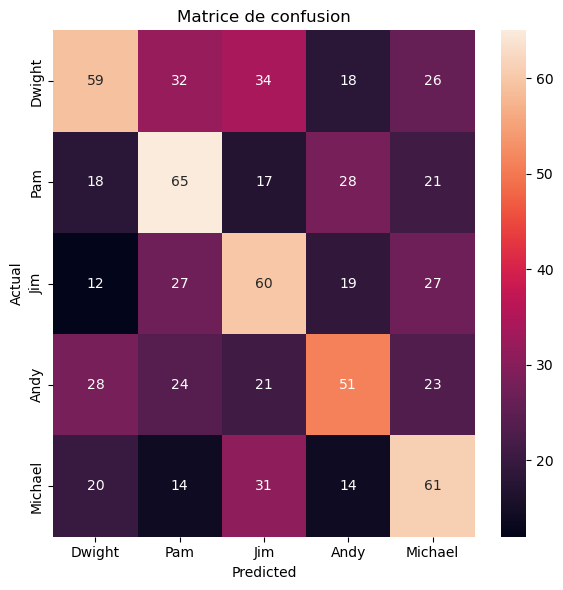

In [550]:
from sklearn.metrics import classification_report, f1_score

y_pred = svm_classifier.predict(X_test_vectorized)

print(classification_report(y_test, y_pred))
print("Micro-average F1 score:", f1_score(y_test, y_pred, average='micro'))

# Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title('Matrice de confusion')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Régression logistique

In [551]:
from sklearn.linear_model import LogisticRegression

rl_classifier = LogisticRegression()
rl_classifier.fit(X_train_vectorized, y_train)

LogisticRegression()

              precision    recall  f1-score   support

        Andy       0.42      0.36      0.38       169
      Dwight       0.41      0.44      0.43       149
         Jim       0.36      0.42      0.39       145
     Michael       0.41      0.35      0.38       147
         Pam       0.42      0.45      0.43       140

    accuracy                           0.40       750
   macro avg       0.40      0.40      0.40       750
weighted avg       0.40      0.40      0.40       750

Micro-average F1 score: 0.4026666666666667


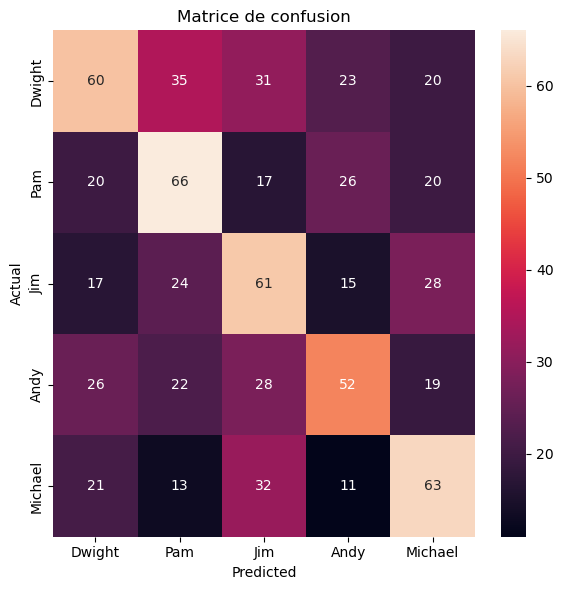

In [552]:
from sklearn.metrics import classification_report, f1_score

y_pred = rl_classifier.predict(X_test_vectorized)

print(classification_report(y_test, y_pred))
print("Micro-average F1 score:", f1_score(y_test, y_pred, average='micro'))

# Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title('Matrice de confusion')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Random Forest

In [553]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_vectorized, y_train)

RandomForestClassifier(random_state=0)

              precision    recall  f1-score   support

        Andy       0.38      0.33      0.35       169
      Dwight       0.37      0.44      0.40       149
         Jim       0.30      0.37      0.33       145
     Michael       0.37      0.21      0.27       147
         Pam       0.33      0.38      0.35       140

    accuracy                           0.35       750
   macro avg       0.35      0.35      0.34       750
weighted avg       0.35      0.35      0.34       750

Micro-average F1 score: 0.3466666666666667


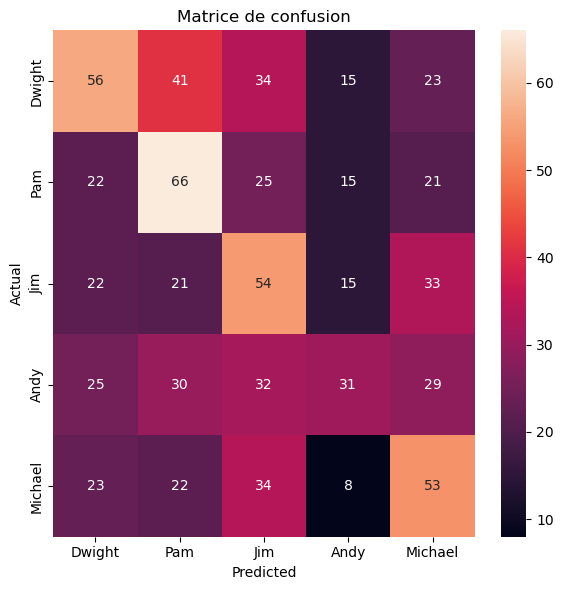

In [554]:
from sklearn.metrics import classification_report, f1_score

y_pred = rf_classifier.predict(X_test_vectorized)

print(classification_report(y_test, y_pred))
print("Micro-average F1 score:", f1_score(y_test, y_pred, average='micro'))

# Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title('Matrice de confusion')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Gradient Boosting

In [555]:
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=0)
gb_classifier.fit(X_train_vectorized, y_train)

GradientBoostingClassifier(random_state=0)

              precision    recall  f1-score   support

        Andy       0.44      0.31      0.37       169
      Dwight       0.33      0.36      0.34       149
         Jim       0.30      0.36      0.33       145
     Michael       0.38      0.31      0.34       147
         Pam       0.32      0.40      0.36       140

    accuracy                           0.35       750
   macro avg       0.35      0.35      0.35       750
weighted avg       0.36      0.35      0.35       750

Micro-average F1 score: 0.3466666666666667


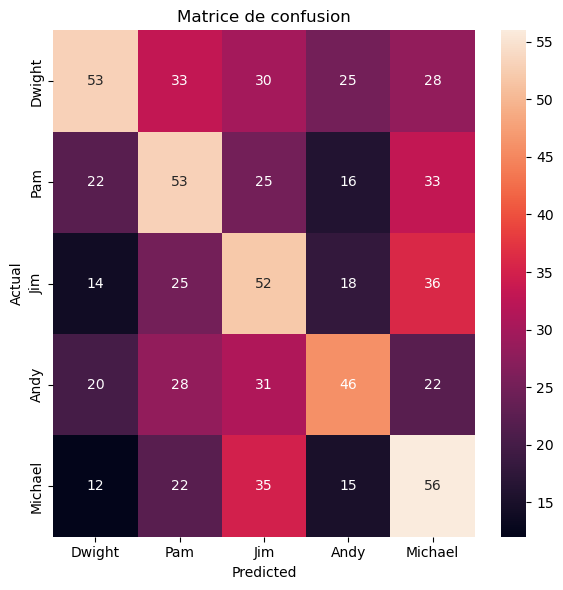

In [556]:
from sklearn.metrics import classification_report, f1_score

y_pred = gb_classifier.predict(X_test_vectorized)

print(classification_report(y_test, y_pred))
print("Micro-average F1 score:", f1_score(y_test, y_pred, average='micro'))

# Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title('Matrice de confusion')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [559]:
# Sauvegarde du modèle de classification Regression Logistique
import joblib

joblib.dump(rl_classifier, 'rl_classifier.joblib')

# Sauvegarde du modèle de vectorisation
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']